#Importing Libraries

In [ ]:
import os
import numpy as np
import zipfile
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import glorot_uniform

##Data Loading and Preprocessing

In [ ]:
# Path to the uploaded zip file
zip_path = '/content/sorted_data.zip'

# Extract to /content/sorted_data
extract_path = '/content/data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted to {extract_path}")

Extracted to /content/data


In [ ]:
#Load and preprocess the data
# Paths to images and masks directories
image_dir = "/content/data/sorted_images"
mask_dir = "/content/data/sorted_masks"

# Load images and masks
def load_data(image_dir, mask_dir):
    images = []
    for filename in sorted(os.listdir(image_dir)) :
        img_path = os.path.join(image_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (256, 256))
        # Normalize image and resize mask
        images.append(image / 255.0)
    masks=[]
    for filename in sorted(os.listdir(mask_dir)) :
        mask_path = os.path.join(mask_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        # Normalize image and resize mask
        masks.append(mask / 255.0)




    return np.array(images), np.expand_dims(np.array(masks), axis=-1)


images, masks = load_data(image_dir, mask_dir)

In [ ]:
SEED = 42
tf.random.set_seed(SEED)

In [ ]:
# Split into training , validation sets and testing set

X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.2, random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)


##Model

In [ ]:
#Unet model

def unet_model(input_size=(256, 256, 3), seed=42):
    initializer = glorot_uniform(seed=seed)  # Define the seeded initializer

    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer=initializer)(c9)
    model = Model(inputs, outputs)
    return model


In [ ]:
def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to 0 or 1
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=[1, 2, 3])  # True positives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=[1, 2, 3])  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=[1, 2, 3])  # False negatives

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)


In [ ]:
# Import the optimizer
from tensorflow.keras.optimizers import SGD

# Create an SGD optimizer with momentum
optimizer = SGD(learning_rate=0.1, momentum=0.9)

In [ ]:
model = unet_model()
model.compile(optimizer=optimizer , loss='binary_crossentropy',  metrics=['accuracy', f1_score])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.7660 - f1_score: 0.8997 - loss: 0.0901 - val_accuracy: 0.7600 - val_f1_score: 0.8617 - val_loss: 0.1465
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 794ms/step - accuracy: 0.7658 - f1_score: 0.9041 - loss: 0.0873 - val_accuracy: 0.7617 - val_f1_score: 0.8530 - val_loss: 0.1572
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 808ms/step - accuracy: 0.7663 - f1_score: 0.9052 - loss: 0.0863 - val_accuracy: 0.7584 - val_f1_score: 0.8635 - val_loss: 0.1432
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 811ms/step - accuracy: 0.7660 - f1_score: 0.9049 - loss: 0.0872 - val_accuracy: 0.7588 - val_f1_score: 0.8619 - val_loss: 0.1518
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 839ms/step - accuracy: 0.7661 - f1_score: 0.9056 - loss: 0.0860 - val_accuracy: 0.7592 - val_f1_score: 0.8604 - val_loss: 0.1622
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 41s 848ms/step - accuracy: 0.7665 - f1_score: 0.9104 - loss: 0.0826 - val_accuracy: 0.7612 - val_f1_s

In [ ]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Threshold predictions at 0.5

# Threshold y_test to binary
y_test_binary = (y_test > 0.5).astype(np.uint8)  # Threshold ground truth at 0.5

# Flatten the arrays to compute pixel-wise F1 score
y_test_flat = y_test_binary.flatten()
y_pred_flat = y_pred.flatten()

# Compute F1 Score
f1 = f1_score(y_test_flat, y_pred_flat)
print("F1 Score on Test Data:", f1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
F1 Score on Test Data: 0.9164503336116052


In [ ]:
from sklearn.metrics import f1_score

# Threshold y_test to binary
y_test_binary = (y_test > 0.5).astype(np.uint8)  # Threshold ground truth at 0.5

# Flatten the arrays
y_test_flat = y_test_binary.flatten()
y_pred_flat = y_pred.flatten()

# Compute F1 Score
f1 = f1_score(y_test_flat, y_pred_flat)
print("F1 Score on Test Data:", f1)


F1 Score on Test Data: 0.9164503336116052


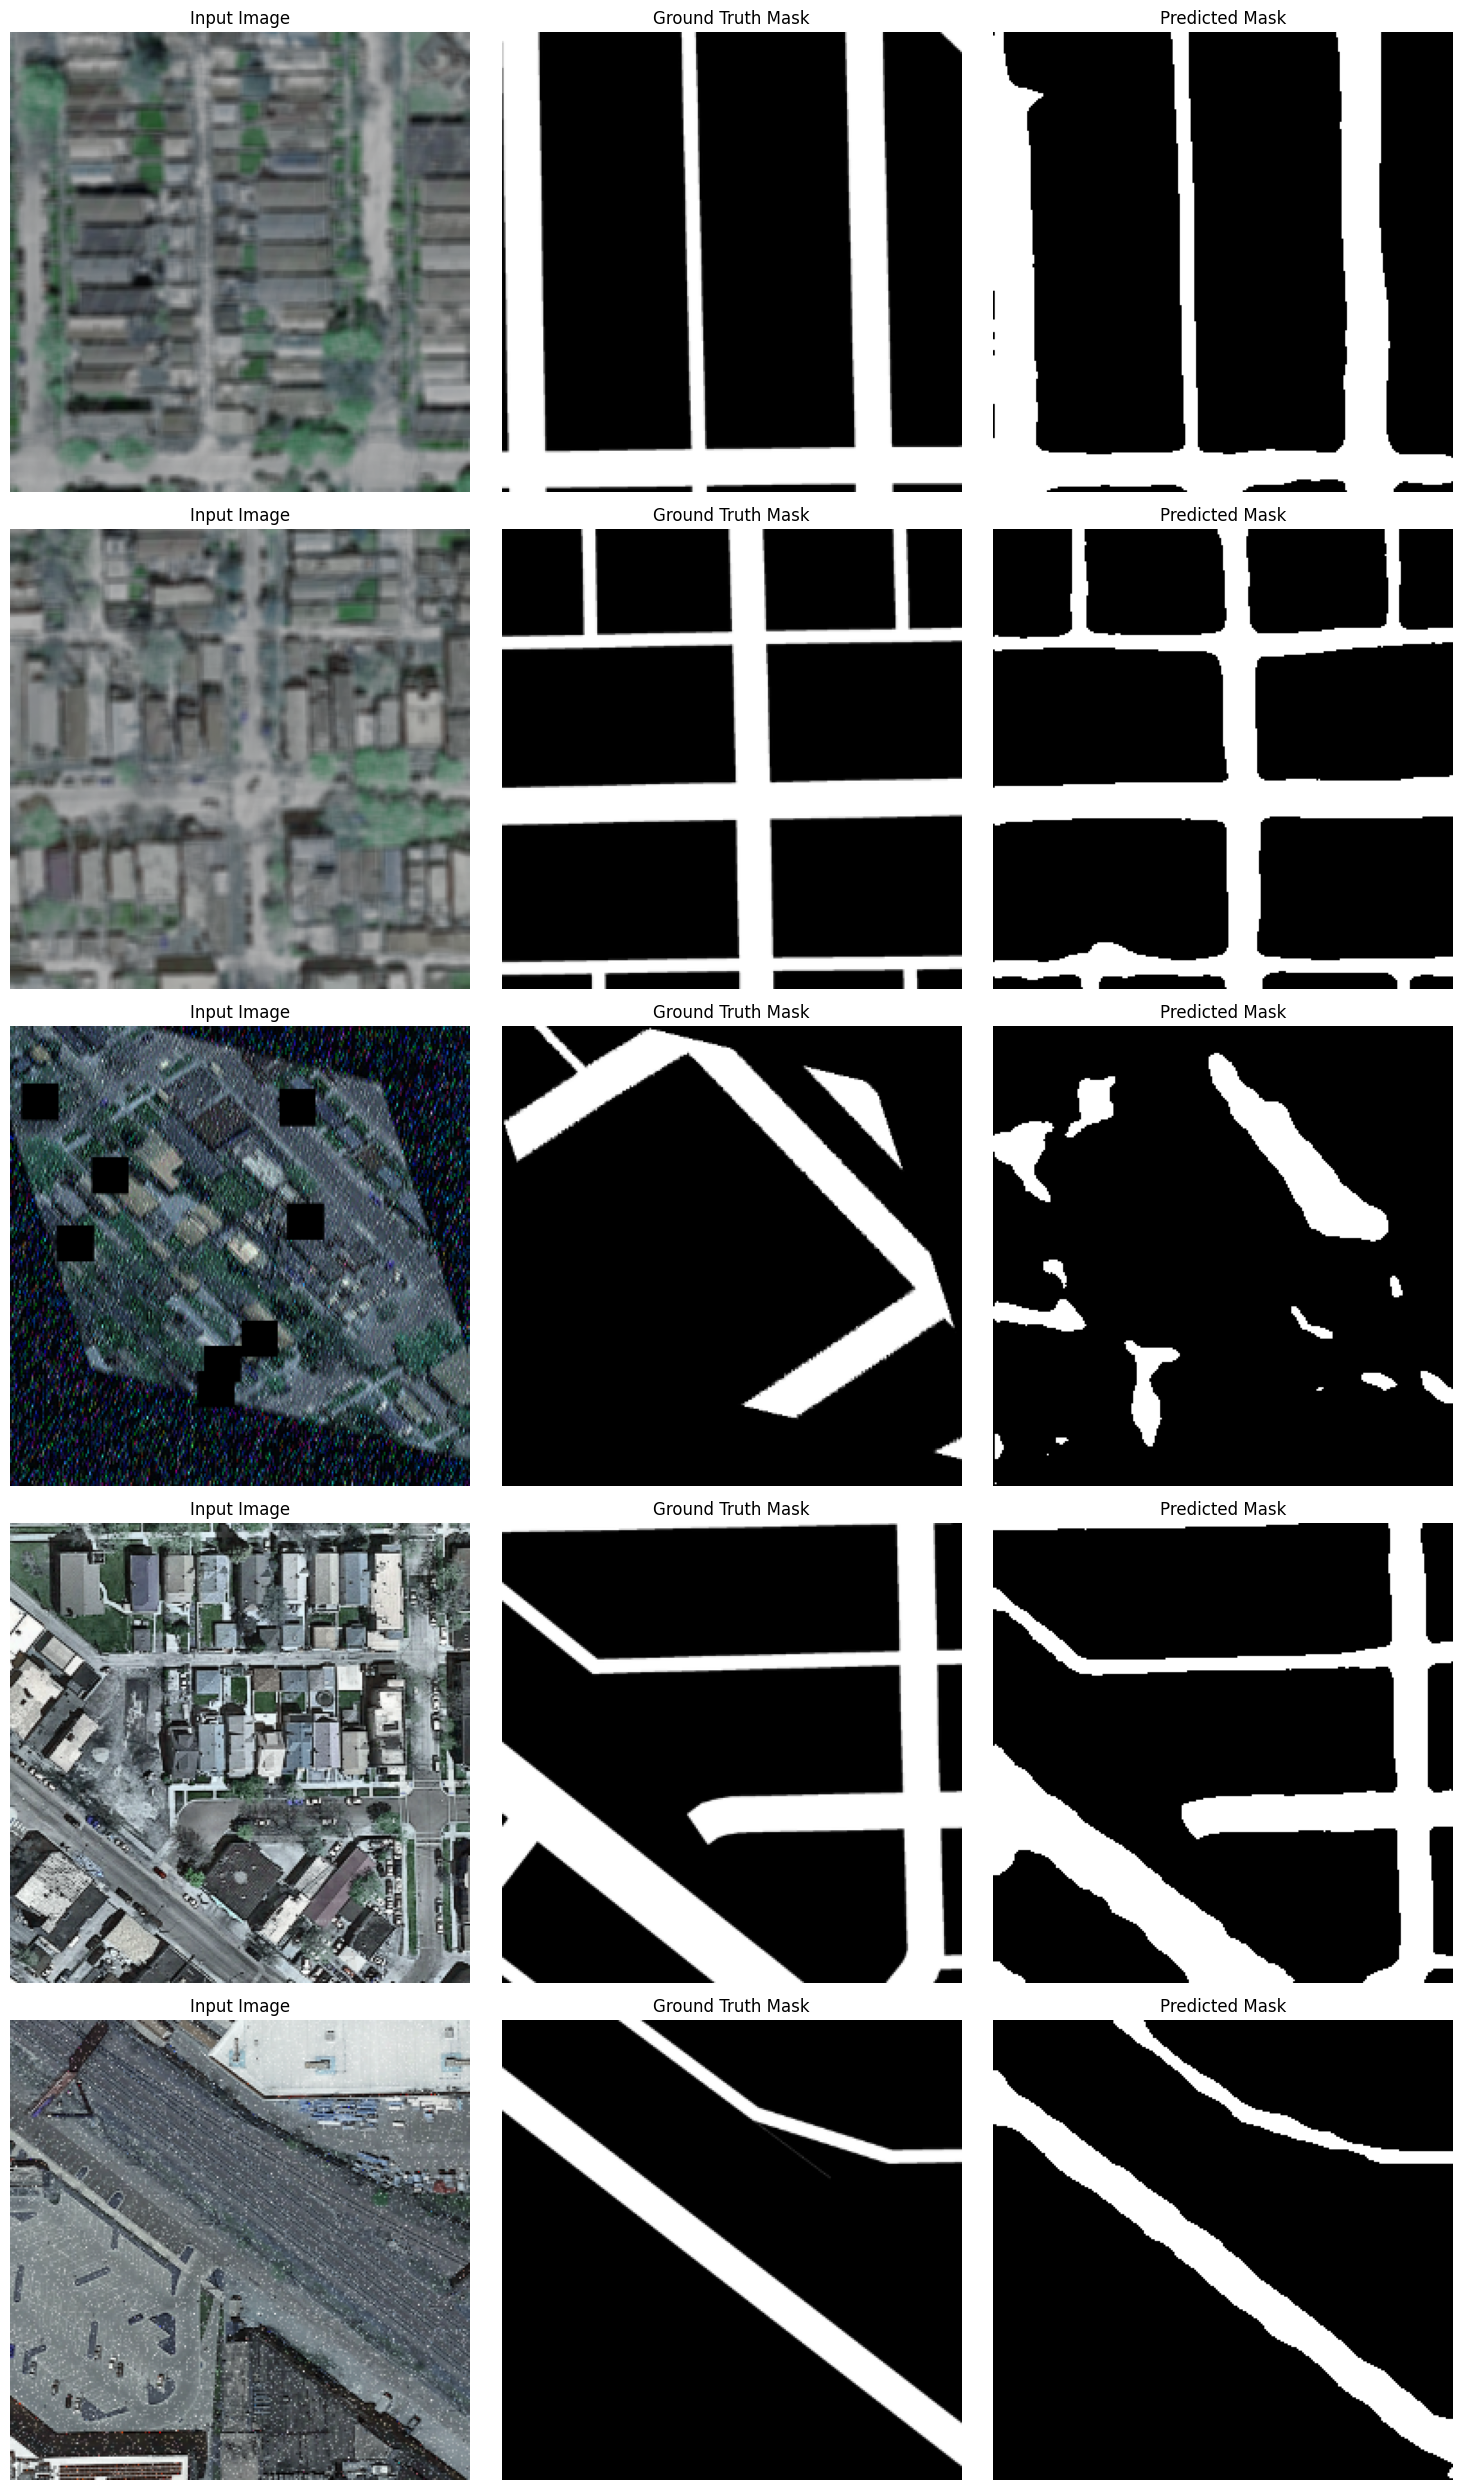

In [ ]:
# Select a few samples for visualization
num_samples = 5  # Number of samples to visualize
indices = np.random.choice(len(X_test), num_samples, replace=False)

# Plot the results
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for i, idx in enumerate(indices):
    # Input image
    input_image = X_test[idx]
    ground_truth = y_test[idx].squeeze()
    predicted_mask = y_pred[idx].squeeze()

    # Plot Input Image
    axes[i, 0].imshow(input_image)
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # Plot Ground Truth Mask
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # Plot Predicted Mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Save the entire model
model.save("road_segmentation_Unet_sgd.h5")  # Save as HDF5 file
# Save the model weights
model.save_weights("road_segmentation_Unet_sgd.weights.h5")